<a href="https://www.kaggle.com/code/clemwo/competition-nlp-with-disaster-tweets?scriptVersionId=197357702" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# 🔥Competition 🏆 NLP with Disaster Tweets🦜

This notebooks builds models for [Kaggles Desaster Tweets 🦜 competition](https://www.kaggle.com/competitions/nlp-getting-started). The objective is to develop a model to predict which Tweets are about real disasters and which ones are not. The submission evaluation metric is the [F1-Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) between the predicted and expected answers. The format of the submission file submission.csv should be as follows:
```
id,target
0,0
2,0
3,1
9,0
11,0
```
where `1` stands for a tweet describing a real disaster, and `0` otherwise.

In [2]:
tweets = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print(f"Rows: {tweets.shape[0]:,}")
print(f"Cols: {tweets.shape[1]:,}")
tweets.head(5)

Rows: 7,613
Cols: 5


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Seems that `text` is the most useful column to use to predict the `target`. However, the columns are described as follows: 

| Column | Description |
|:-------|:------------|
| `keyword` | A keyword from that tweet (this may be blank). | 
| `location` | The location the tweet was sent from (this may be blank). | 
| `text` | The text of the tweet. | 
| `target` | $1$ if the tweet is about a real desaster, $0$ otherwise. |

In [3]:
TWITTER_BLUE = '#008AD8'

# Overview of the Data

In [4]:
stats = pd.DataFrame({
    'Variable Name': tweets.columns,
    'Missing Count': tweets.isnull().sum().values,
    'Missing Rate (%)': 100*tweets.isnull().mean().values,
    'Unique Count': tweets.nunique().values,
    'Unique Rate (%)': 100*tweets.nunique().values / len(tweets)
}).sort_values(['Missing Rate (%)'], ascending=False)
stats

,Variable Name,Missing Count,Missing Rate (%),Unique Count,Unique Rate (%)
2,location,2533,33.272035,3341,43.885459
1,keyword,61,0.801261,221,2.902929
0,id,0,0.000000,7613,100.000000
3,text,0,0.000000,7503,98.555103
4,target,0,0.000000,2,0.026271


- 33% of all the tweets don't have information about their location.
- Only 0.8% of all the tweest don't have information about a keyword from that tweet.
- there are only 221 (2.9%) unique keywords in all the training set.
- There are no empy tweets 😄 Meaning, every tweet has some text.

Let's try to understand the variation of lengths of the tweets in the dataset. 

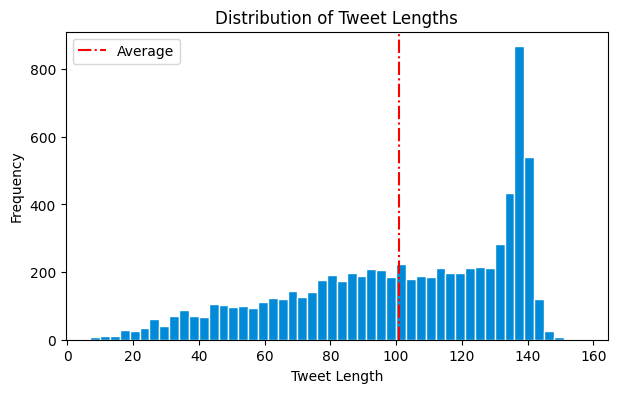

In [5]:
# ---------------- #
# Length of tweets #
# ---------------- #

tweet_lengths = tweets['text'].apply(lambda x: len(x))
avg_length = np.mean(tweet_lengths)

plt.figure(figsize=(7, 4))
plt.hist(tweet_lengths, bins=50, color=TWITTER_BLUE, edgecolor='white');
plt.axvline(avg_length, color='red', linestyle='-.', label='Average')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Tweet Lengths', fontsize=12)

plt.show()

---

💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏